In [1]:
%cd ..

/fs01/home/abbasgln/codes/medAI/projects/tta


/h/abbasgln/.conda/envs/mttt/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [7]:
import math
import os
from dotenv import load_dotenv
# Loading environment variables
load_dotenv()

import sys
sys.path.append(os.getenv("PROJECT_PATH"))


import torch
import torch.nn as nn
import torch.nn.functional as F
import typing as tp
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from dataclasses import dataclass, field
import logging
import wandb

import medAI
from medAI.utils.setup import BasicExperiment, BasicExperimentConfig

from utils.metrics import MetricCalculator

from timm.optim.optim_factory import create_optimizer

from einops import rearrange, repeat
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import timm

from copy import copy, deepcopy
import pandas as pd

from datasets.datasets import ExactNCT2013RFImagePatches
from medAI.datasets.nct2013 import (
    KFoldCohortSelectionOptions,
    LeaveOneCenterOutCohortSelectionOptions, 
    PatchOptions
)

DATA_ROOT = os.environ.get("DATA_ROOT")


In [8]:
LEAVE_OUT='JH'

In [33]:
group=f"offline_MIEnsmMemo_noaug_e-1lr_gn_3ratio_loco"
save_dir = f"/ssd005/projects/exactvu_pca/checkpoint_store/Mahdi/saved_logits/{group}/{LEAVE_OUT}"
logits_labels = torch.load(f"{save_dir}/core_id_probs_labels.pth")
core_id_probs = logits_labels['core_id_probs']
core_id_labels = logits_labels['core_id_labels']
core_probs = probs = torch.stack([torch.stack(probs_list).mean(dim=0) for id, probs_list in core_id_probs.items()])   
core_labels = torch.stack([labels_list[0] for id, labels_list in core_id_labels.items()])
import torchmetrics
torchmetrics.functional.auroc(core_probs, core_labels, task="multiclass", num_classes=2, thresholds=np.arange(0.,1.,0.0001).tolist())

tensor(0.7473)

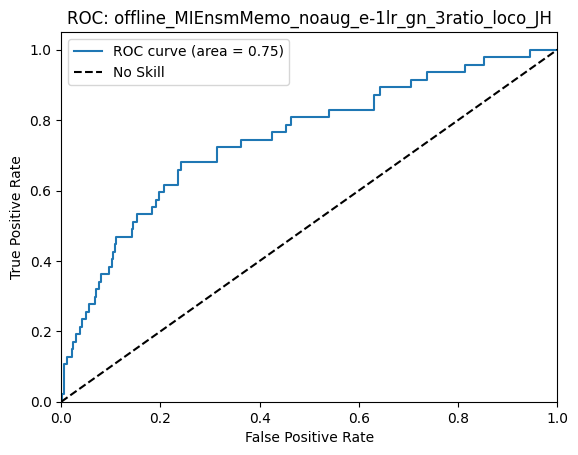

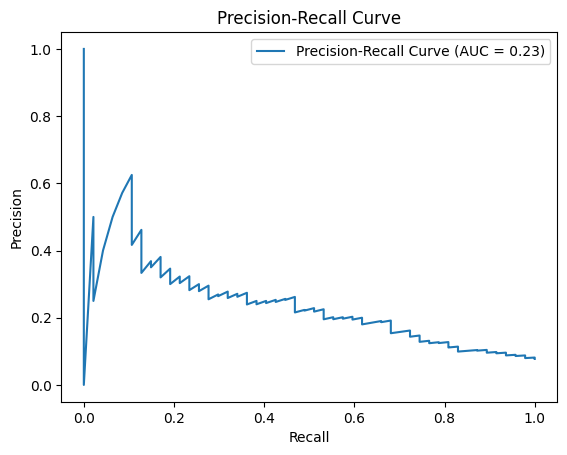

In [34]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(core_labels.numpy(), core_probs.numpy()[:,1]) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC: {group}_{LEAVE_OUT}')
plt.legend()
plt.show()

precision, recall, thresholds = precision_recall_curve(core_labels.numpy(), core_probs.numpy()[:,1]) 
auc_score = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [35]:
thr_ = thresholds[::5]
thr_

array([0.00059625, 0.00131252, 0.00138082, 0.00151224, 0.00155399,
       0.00162946, 0.00167147, 0.00175899, 0.00182799, 0.00188727,
       0.00190728, 0.00194012, 0.00198057, 0.00200553, 0.00203719,
       0.00207547, 0.00211817, 0.00213483, 0.00215644, 0.00216379,
       0.00218323, 0.00219429, 0.00220624, 0.00224949, 0.00228889,
       0.00230409, 0.00232089, 0.00234476, 0.00239279, 0.00240544,
       0.00243844, 0.00248509, 0.00250373, 0.00251943, 0.0025413 ,
       0.00257198, 0.002594  , 0.00261596, 0.00262805, 0.00265088,
       0.00268601, 0.00272152, 0.00274609, 0.0027751 , 0.00281981,
       0.00284287, 0.00286918, 0.00290821, 0.0029224 , 0.00294863,
       0.00297008, 0.00302021, 0.0030486 , 0.00308125, 0.00310273,
       0.00312787, 0.00314723, 0.00320391, 0.00322937, 0.00328121,
       0.00331936, 0.0033982 , 0.00343231, 0.00345465, 0.00347227,
       0.00353941, 0.0035685 , 0.00361417, 0.00363639, 0.00369613,
       0.00373878, 0.00379577, 0.00384664, 0.00392318, 0.00403

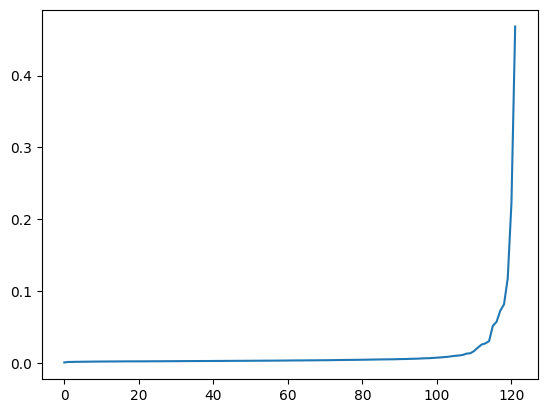

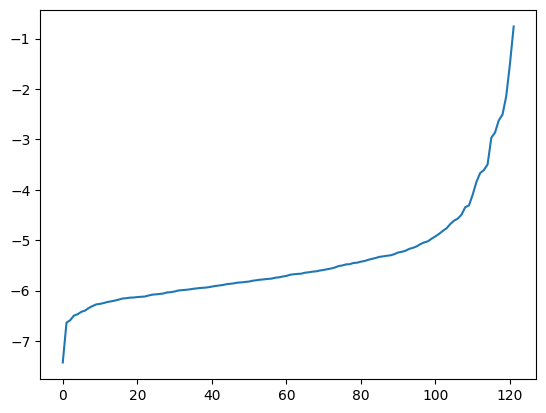

In [36]:
plt.plot(range(len(thr_)), thr_)
plt.figure()
plt.plot(range(len(thr_)), np.log(thr_))

In [10]:
group=f"offline_MIensemble_10mi_5mdls_3ratio_gn_loco2"
save_dir = f"/ssd005/projects/exactvu_pca/checkpoint_store/Mahdi/saved_logits/{group}/{LEAVE_OUT}"
logits_labels = torch.load(f"{save_dir}/core_id_probs_labels.pth")
core_id_probs = logits_labels['core_id_probs']
core_id_labels = logits_labels['core_id_labels']
core_probs = probs = torch.stack([torch.stack(probs_list).mean(dim=0) for id, probs_list in core_id_probs.items()])   
core_labels = torch.stack([labels_list[0] for id, labels_list in core_id_labels.items()])
import torchmetrics
torchmetrics.functional.auroc(core_probs, core_labels, task="multiclass", num_classes=2, thresholds=np.arange(0.,1.,0.0001).tolist())

tensor(0.7124)

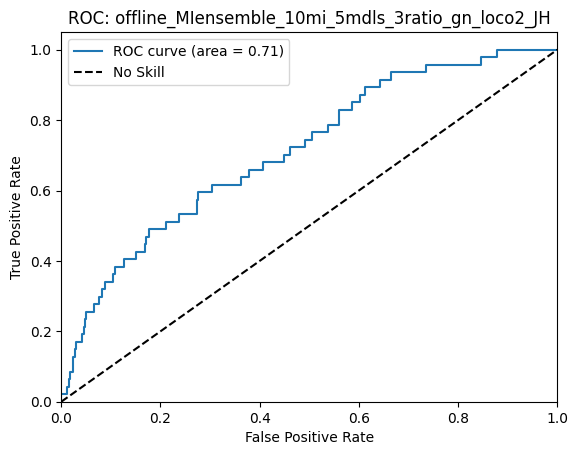

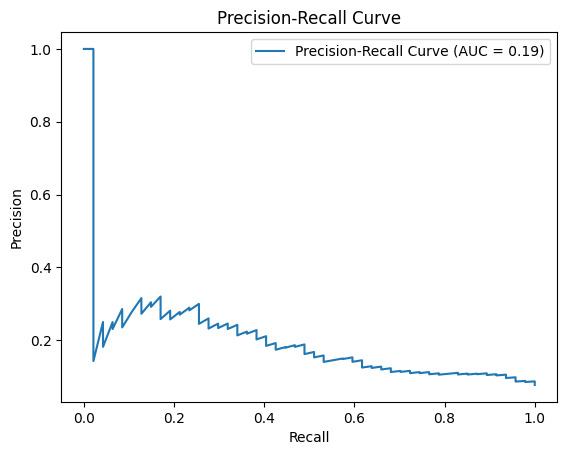

In [11]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(core_labels.numpy(), core_probs.numpy()[:,1]) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC: {group}_{LEAVE_OUT}')
plt.legend()
plt.show()

precision, recall, thresholds = precision_recall_curve(core_labels.numpy(), core_probs.numpy()[:,1]) 
auc_score = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [20]:
group=f"offline_ensemble_5mdls_gn_3ratio_loco"
save_dir = f"/ssd005/projects/exactvu_pca/checkpoint_store/Mahdi/saved_logits/{group}/{LEAVE_OUT}"
logits_labels = torch.load(f"{save_dir}/core_id_probs_labels.pth")
core_id_probs = logits_labels['core_id_probs']
core_id_labels = logits_labels['core_id_labels']
core_probs = probs = torch.stack([torch.stack(probs_list).mean(dim=0) for id, probs_list in core_id_probs.items()])   
core_labels = torch.stack([labels_list[0] for id, labels_list in core_id_labels.items()])
import torchmetrics
torchmetrics.functional.auroc(core_probs, core_labels, task="multiclass", num_classes=2, thresholds=np.arange(0.,1.,0.0001).tolist())

tensor(0.7058)

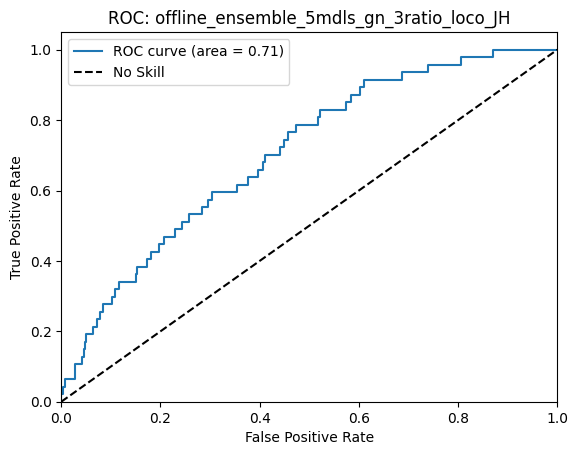

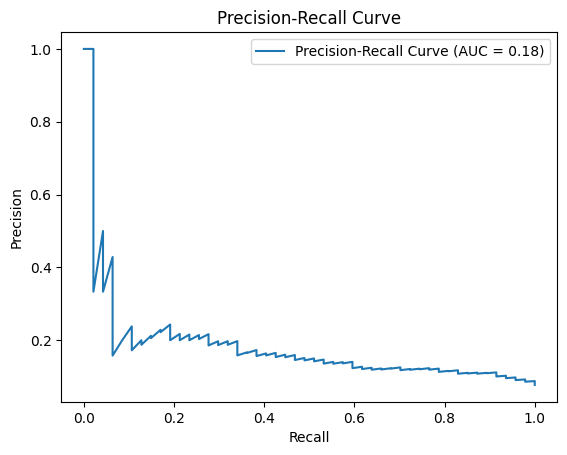

In [21]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(core_labels.numpy(), core_probs.numpy()[:,1]) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC: {group}_{LEAVE_OUT}')
plt.legend()
plt.show()

precision, recall, thresholds = precision_recall_curve(core_labels.numpy(), core_probs.numpy()[:,1]) 
auc_score = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [22]:
thr_ = thresholds[::5]
thr_

array([0.03391581, 0.06395481, 0.07641021, 0.09423561, 0.11143887,
       0.11902044, 0.1303344 , 0.13324106, 0.13624616, 0.14281635,
       0.15040177, 0.15949062, 0.16536665, 0.16991273, 0.17478794,
       0.17999384, 0.18280968, 0.18867575, 0.19422358, 0.19654393,
       0.19982274, 0.20427522, 0.21025956, 0.2139864 , 0.2186118 ,
       0.22412704, 0.2261843 , 0.2322233 , 0.23473103, 0.23971088,
       0.2445777 , 0.24582647, 0.24769346, 0.25249067, 0.25721833,
       0.2620297 , 0.26326337, 0.26823583, 0.27000985, 0.27282748,
       0.27655122, 0.28125387, 0.28299338, 0.28560114, 0.28825876,
       0.29113394, 0.29323685, 0.29654244, 0.30170915, 0.3022515 ,
       0.3051622 , 0.30860183, 0.3104462 , 0.31390342, 0.3170277 ,
       0.31902713, 0.32248822, 0.32762113, 0.32962564, 0.33330834,
       0.33663136, 0.34010136, 0.3429267 , 0.34617633, 0.34709987,
       0.34993935, 0.35511094, 0.3568732 , 0.3609747 , 0.36388347,
       0.36507052, 0.36581495, 0.37561497, 0.37722242, 0.38092

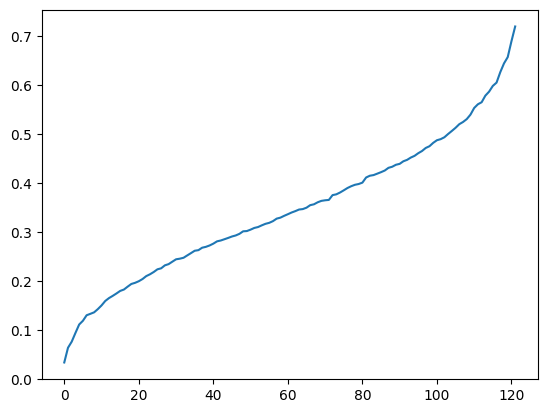

In [23]:
plt.plot(range(len(thr_)), thr_)


## Average all centers

In [59]:
import torchmetrics
CORE = pd.read_csv(os.path.join(DATA_ROOT, "cores_dataset", "core.csv"))
group=f"offline_MIEnsmMemo_noaug_e-1lr_gn_3ratio_loco"


accs = []
aurocs = []
best_thrs = []
for leave_out in ["JH" , "PCC", "PMCC", "UVA", "CRCEO"]:
    save_dir = f"/ssd005/projects/exactvu_pca/checkpoint_store/Mahdi/saved_logits/{group}/{leave_out}"
    logits_labels = torch.load(f"{save_dir}/core_id_probs_labels.pth")
    core_id_probs = logits_labels['core_id_probs']
    core_id_labels = logits_labels['core_id_labels']
    
    # Filter out cores with high invasiveness
    high_inv_ids = CORE[CORE['id'].isin(core_id_probs.keys()) & (np.isnan(CORE['pct_cancer']) | (CORE['pct_cancer'] >= 40))]['id'].values
    core_id_probs = {id: core_id_probs[id] for id in high_inv_ids}
    core_id_labels = {id: core_id_labels[id] for id in high_inv_ids}
        
    core_probs = probs = torch.stack([torch.stack(probs_list).mean(dim=0) for id, probs_list in core_id_probs.items()])   
    core_labels = torch.stack([labels_list[0] for id, labels_list in core_id_labels.items()])
    fpr, tpr, thresholds = roc_curve(core_labels.numpy(), core_probs.numpy()[:,1]) 
    best_thr = thresholds[((tpr + 1 - fpr)/2).argmax()]
    best_thrs.append(best_thr)
    auroc = torchmetrics.functional.auroc(core_probs, core_labels, task="multiclass", num_classes=2)
    tp, fp, tn, fn, _ = torchmetrics.functional.stat_scores(preds=core_probs[:,1]>=best_thr, target=core_labels, task="binary", average="macro")
    accs.append((tp/(tp+fn) + tn/(tn+fp))/2)
    aurocs.append(auroc)    

np.mean(accs), np.mean(aurocs)

(0.75596714, 0.80510557)

In [60]:
np.std(accs)

0.03407983

## Baseline batch/group norm bar plots

In [1]:
batch_norm_auc = {"JH": [0.6444,0.7269], "PCC": [0.7225,0.6996], "PMCC": [0.8162, 0.7998], "UVA": [0.792, 0.7833], "CRCEO": [0.7852, 0.7643]}
batch_norm_auc_all = {"JH": [0.6234,0.6664], "PCC": [0.6837, 0.6583], "PMCC": [0.7712,0.7385], "UVA": [0.7174, 0.7024], "CRCEO": [0.6407, 0.633]}


group_norm_auc = {"JH": [0.7393, 0.7486 ], "PCC": [0.7257, 0.7284], "PMCC": [0.8231, 0.8206], "UVA": [0.7759,0.7580], "CRCEO": [0.8292, 0.823]}
group_norm_auc_all = {"JH": [0.6814,0.686 ], "PCC": [0.6806, 0.6799], "PMCC": [0.7678, 0.7668], "UVA": [0.7179,0.6927], "CRCEO": [0.7353, 0.7311]}

In [5]:
batch_norm_auc_all = {key: 100*np.array(values) for key, values in batch_norm_auc_all.items()}
group_norm_auc_all = {key: 100*np.array(values) for key, values in group_norm_auc_all.items()}

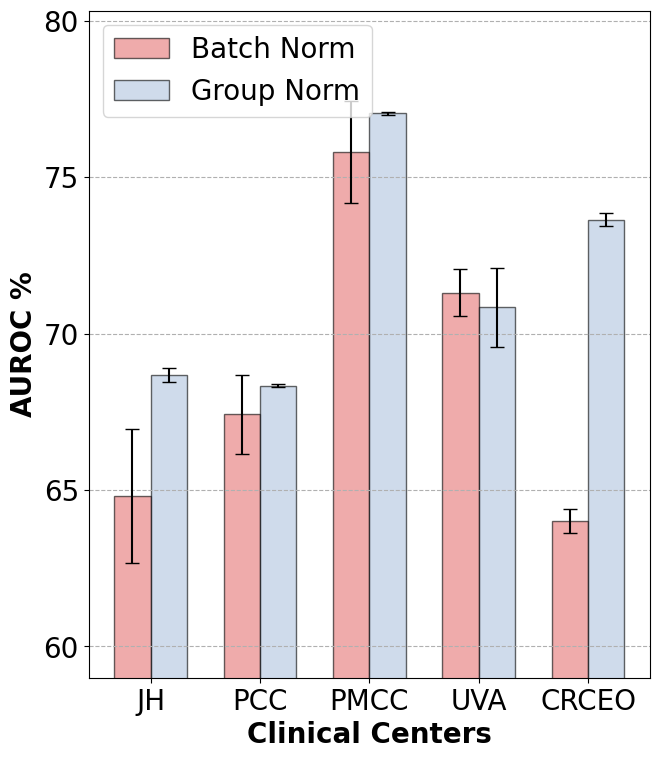

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the means and standard deviations
batch_norm_means = {key: np.mean(values) for key, values in batch_norm_auc_all.items()}
group_norm_means = {key: np.mean(values) for key, values in group_norm_auc_all.items()}

batch_norm_stds = {key: np.std(values) for key, values in batch_norm_auc_all.items()}
group_norm_stds = {key: np.std(values) for key, values in group_norm_auc_all.items()}

# Extract keys and values for plotting
centers = list(batch_norm_means.keys())
batch_means = [batch_norm_means[center] for center in centers]
group_means = [group_norm_means[center] for center in centers]

batch_stds = [batch_norm_stds[center] for center in centers]
group_stds = [group_norm_stds[center] for center in centers]

# Determine the minimum value for y-axis
min_value = min(min(batch_means), min(group_means)) - 5  # Adjust based on your data

# Bar plot
width = 0.2 # the width of the bars
x = np.arange(len(centers))*3*width # the label locations

# # Setting font properties
# plt.rcParams['font.family'] = 'Times New Roman'
# plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.size'] = 20

fig, ax = plt.subplots(figsize=(7, 8))
bars1 = ax.bar(x - width/2, batch_means, width, yerr=batch_stds, label='Batch Norm', capsize=5, alpha=0.6, color='#E57373', edgecolor='black')
bars2 = ax.bar(x + width/2, group_means, width, yerr=group_stds, label='Group Norm', capsize=5, alpha=0.6, color='#B0C4DE', edgecolor='black')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Clinical Centers',fontweight='bold')
ax.set_ylabel('AUROC %', fontweight='bold')
# ax.set_title('Batch Norm vs Group Norm Across Clinical Centers')
ax.set_xticks(x)
ax.set_xticklabels(centers)
ax.set_ylim([min_value, 80])  # Adjust based on your data
ax.legend()

# Add horizontal dotted lines
ax.grid(axis='y', linestyle='--')

# Remove decimals in y-axis labels
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
ax.set_yticks(np.arange(min_value+1, 81, 5))

# # Attach a text label above each bar in *bars1* and *bars2*, displaying its height.
# def autolabel(bars):
#     """Attach a text label above each bar in *bars*, displaying its height."""
#     for bar in bars:
#         height = bar.get_height()
#         ax.annotate('{}'.format(round(height, 4)),
#                     xy=(bar.get_x() + bar.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')

# autolabel(bars1)
# autolabel(bars2)

fig.tight_layout()

plt.show()